# Basic use of fundamental functions

$\newcommand{\bDelta}{\boldsymbol{\Delta}}
\newcommand{\bmu}{\boldsymbol{\mu}}
\newcommand{\bnu}{\boldsymbol{\nu}}
\newcommand{\bsigma}{\boldsymbol{\sigma}}
\newcommand{\bSigma}{\boldsymbol{\Sigma}}
\newcommand{\btheta}{\boldsymbol{\theta}}
\newcommand{\blambda}{\boldsymbol{\lambda}}
\newcommand{\Xs}{X_{\mathrm{s}}}
\newcommand{\Xt}{X_{\mathrm{t}}}
\newcommand{\gs}{\mathbf{g}_{\mathrm{s}}}
\newcommand{\gt}{\mathbf{g}_{\mathrm{t}}}
\newcommand{\Hs}{\mathbf{H}_{\mathrm{s}}}
\newcommand{\Ht}{\mathbf{H}_{\mathrm{t}}}
\newcommand{\caL}{\mathcal{L}}
\newcommand{\bD}{\mathbf{D}}
\newcommand{\be}{\mathbf{e}}
\newcommand{\bg}{\mathbf{g}}
\newcommand{\bG}{\mathbf{G}}
\newcommand{\bH}{\mathbf{H}}
\newcommand{\bI}{\mathbf{I}}
\newcommand{\bJ}{\mathbf{J}}
\newcommand{\bK}{\mathbf{K}}
\newcommand{\bM}{\mathbf{M}}
\newcommand{\bP}{\mathbf{P}}
\newcommand{\bT}{\mathbf{T}}
\newcommand{\bU}{\mathbf{U}}
\newcommand{\bu}{\mathbf{u}}
\newcommand{\bv}{\mathbf{v}}
\newcommand{\bLambda}{\boldsymbol{\Lambda}}
\newcommand{\bfeta}{\boldsymbol{\eta}}$<!--
-->In this example, we show how to use the functions computing $\bar{\bH}$, $\bar{\bg}$, $\bD$ and $\bfeta^*$, where the chosen direction $\bu$ is the opposite of the gradient: $\bu := - \bg$.

## Short reminder

We consider a vector of parameters $\btheta \in \mathbb{R}^P$. We represent this vector by
a tuple of $S$ subsets (or groups) of parameters $(\bT_1, \cdots, \bT_S)$. This tuple can be seen
as a partition of the set of the indices $\{1, \cdots, P\}$ of the vector $\btheta$,
so that each parameter $\theta_p$ belongs to exactly one subset (or group) $\bT_s$.
We assume that $S \ll P$.

The goal consists in finding a vector $\bfeta \in \mathbb{R}^S$ of learning rates,
where each coordinate $\eta_s$ is the learning rate corresponding to a subset $\bT_s$.
At each training step $t$, given a proposition of direction of descent $\bu_t$, we aim to build the
$\bfeta_t$ maximizing the loss decrease. To do so, we take into account second- and third-order information.

Therefore, we define:
$$
\begin{aligned}
\bar{\bH}_t = \bI_{S:P} \bU_t \bH_t \bU_t \bI_{P:S} , \qquad
\bar{\bg}_t = \bI_{S:P} \bU_t \bg_t , \qquad
\bD_t = \mathrm{Diag}(|\bD^{(3)}_{\btheta_t}(\bu_t)|^{1/3}_{iii} : i \in \{1, \cdots, S\}) ,
\end{aligned}
$$
where $\bg_t$ is the gradient of the loss at $\btheta_t$ and $\bH_t$ is its Hessian.
Also, $\bU_t = \mathrm{Diag}(\bu_t)$, $\bI_{S:P}$ is the partition matrix: $(\bI_{S:P})_{sp} = 1$ iff $\theta_p \in \bT_s$ else $0$, 
$\bI_{P:S} = \bI_{S:P}^T$. Note that: $\bar{\bH}_t \in \mathbb{R}^{S \times S}$, $\bar{\bg}_t \in \mathbb{R}^{S}$, $\bD_t \in \mathbb{R}^{S \times S}$.

The training step of our method is: $\btheta_{t + 1} = \btheta_t - \bU_t \bI_{P:S} \bfeta_t^*$, where
$\bfeta_t^*$ is the solution of largest norm $\|\bD_t \bfeta\|$ of the equation:
$$
\begin{aligned}
\bfeta &= \left(\bar{\bH}_t + \frac{\lambda_{\mathrm{int}}}{2} \|\bD_t \bfeta\| \bD_t^2\right)^{-1}\bar{\bg}_t ,
\end{aligned}
$$
where $\lambda_{\mathrm{int}}$ is the internal damping, which is a hyperparameter to set.

## Preparation

We build a small dataset and a small model.

In [1]:
import numpy as np
import torch
import matplotlib
from matplotlib import pyplot as plt
from grnewt import compute_Hg, nesterov_lrs, fullbatch_gradient
from grnewt import partition as build_partition
%matplotlib inline

/home/wolinski/miniconda3/envs/pytorch/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'libc10_cuda.so: cannot open shared object file: No such file or directory'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
# Build dummy regression dataset

size_in = 5
size_out = 4
batch_size = 10

data_in = torch.randn(batch_size, size_in)
data_tar = torch.randn(batch_size, size_out)

dataset = torch.utils.data.TensorDataset(data_in, data_tar)
data_loader = torch.utils.data.DataLoader(dataset, batch_size)

In [3]:
# Define simple model

size_hidden = 6
act_function_cl = torch.nn.Tanh

class Model(torch.nn.Module):
    def __init__(self):
        super(Model, self).__init__()

        self.hidden_layer = torch.nn.Linear(size_in, size_hidden)
        self.activation = act_function_cl()
        self.out_layer = torch.nn.Linear(size_hidden, size_out)

    def forward(self, x):
        x = self.hidden_layer(x)
        x = self.activation(x)
        return self.out_layer(x)

In [4]:
# Build model
model = Model()

## Build the partition

*Sub-package* `grnewt.partition`.

We build the partition of the parameters, which can be:
 * `canonical`: one tensor per subset;
 * `trivial`: all the parameters in the same subset;
 * `wb`: all the weights in one subset, all the biases in another one, and all the remaining parameters in a third one if necessary;
 * any custom partition.

We build also some constants useful for the subsequent computation.

In [5]:
# List of parameters
tup_params = list(model.parameters())

# Partition of the parameters
param_groups, name_groups = build_partition.canonical(model) # canonical, trivial, wb
nb_groups = len(name_groups)

# List of sizes of each subset
group_sizes = [len(pgroup['params']) for pgroup in param_groups]

# List of starting index and ending index of each subset
group_indices = [0] + list(np.cumsum(group_sizes))

# Show the partition
print(f'Partition with {nb_groups} subset(s).')
for idx, ngroup in enumerate(name_groups):
    print(f'Subset #{idx} (size = {len(ngroup)}):')
    for name in ngroup:
        print(f'    {name}')

Partition with 4 subset(s).
Subset #0 (size = 1):
    hidden_layer.weight
Subset #1 (size = 1):
    hidden_layer.bias
Subset #2 (size = 1):
    out_layer.weight
Subset #3 (size = 1):
    out_layer.bias


## Computation of $\bar{\bH}$, $\bar{\bg}$ and $\bD$

*Function* `grnewt.hg.compute_Hg`.

*Function* `grnewt.util.fullbatch.fullbatch_gradient` *(to compute the direction* $\bu$*).*

Note: $\bD$ is singular when using the MSE loss on the top of a model whose last layer is linear. In that case, anisotropic Nesterov regularization is impossible (or must be adapted)

In [6]:
# Build losses

#loss_fn = torch.nn.MSELoss()    # order3
loss_fn = lambda x, y: (x - y).pow(2).mean().sqrt()
full_loss = lambda x, y: loss_fn(model(x), y)

In [7]:
# Compute the direction of training

gradient = fullbatch_gradient(model, loss_fn, tup_params, data_loader, batch_size)
direction = tuple(-grad for grad in gradient)

In [8]:
# Compute H, g, order3

H, g, order3 = compute_Hg(tup_params, full_loss, data_in, data_tar, direction, 
           param_groups = param_groups, group_sizes = group_sizes, group_indices = group_indices)

Text(0.5, -0.16, '$\\mathbf{D}$')

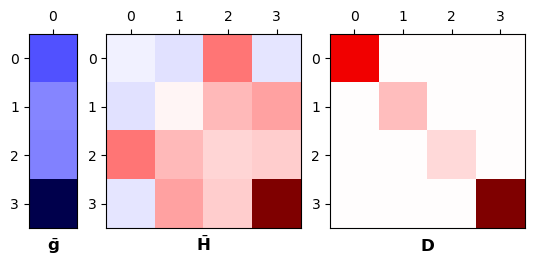

In [9]:
# Plot H, g, order3

fig, ax = plt.subplots(1, 3, width_ratios = [1/nb_groups, 1, 1])

ticks = list(range(nb_groups))

gmax = g.abs().max()
ax[0].matshow(g.unsqueeze(1), cmap = 'seismic', vmin = -gmax, vmax = gmax)
ax[0].tick_params(bottom = False)
ax[0].set_xticks([0])
ax[0].set_xticklabels([0])
ax[0].set_yticks(ticks)
ax[0].set_yticklabels(ticks)
ax[0].set_title(r'$\bar{\mathbf{g}}$', y = -.16)

Hmax = H.abs().max()
ax[1].matshow(H, cmap = 'seismic', vmin = -Hmax, vmax = Hmax)
ax[1].tick_params(bottom = False)
ax[1].set_xticks(ticks)
ax[1].set_xticklabels(ticks)
ax[1].set_yticks(ticks)
ax[1].set_yticklabels(ticks)
ax[1].set_title(r'$\bar{\mathbf{H}}$', y = -.16)

regul = order3.abs().pow(2/3)
regul_max = regul.max()
ax[2].matshow(regul.diag(), cmap = 'seismic', vmin = -regul_max, vmax = regul_max)
ax[2].tick_params(bottom = False)
ax[2].set_xticks(ticks)
ax[2].set_xticklabels(ticks)
ax[2].set_yticks(ticks)
ax[2].set_yticklabels(ticks)
ax[2].set_title(r'$\mathbf{D}$', y = -.16)

## Computation of $\bfeta^*$

*Function* `grnewt.nesterov.nesterov_lrs`.

In [10]:
# Compute the learning rates with anisotropic Nesterov regularization
damping_int = 3
lrs, r_root, r_converged = nesterov_lrs(H, g, order3, damping_int = damping_int)

# Without regularization
lrs_without = torch.linalg.solve(H, g)

Text(0.5, -0.09, '$\\boldsymbol{\\eta}^*_{\\text{noregul}}$')

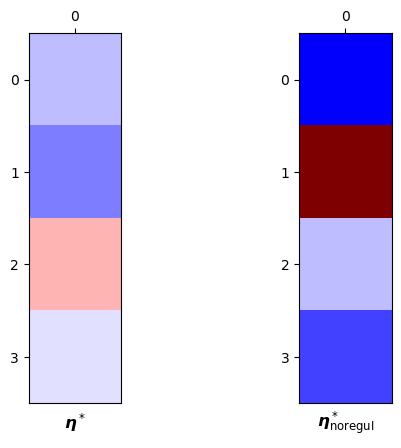

In [11]:
# Plot the learning rates with and without Nesterov regularization

fig, ax = plt.subplots(1, 2, width_ratios = [1, 1])

ticks = list(range(nb_groups))

lrs_max = max(lrs.abs().max(), lrs_without.abs().max())
ax[0].matshow(lrs.unsqueeze(1), cmap = 'seismic', vmin = -lrs_max, vmax = lrs_max)
ax[0].tick_params(bottom = False)
ax[0].set_xticks([0])
ax[0].set_xticklabels([0])
ax[0].set_yticks(ticks)
ax[0].set_yticklabels(ticks)
ax[0].set_title(r'$\boldsymbol{\eta}^*$', y = -.09)

ax[1].matshow(lrs_without.unsqueeze(1), cmap = 'seismic', vmin = -lrs_max, vmax = lrs_max)
ax[1].tick_params(bottom = False)
ax[1].set_xticks([0])
ax[1].set_xticklabels([0])
ax[1].set_yticks(ticks)
ax[1].set_yticklabels(ticks)
ax[1].set_title(r'$\boldsymbol{\eta}^*_{\text{noregul}}$', y = -.09)